# Final Project FTDS 013 Group 3 - Handwritten Signature Forgery Detection

# I. Introduction

- Nama: 
  - Muhamad Ivan (https://github.com/mivanivan)
  - Sheila Monica (https://github.com/sheimonica)
- Batch: FTDS 013
- Dataset: https://www.kaggle.com/datasets/divyanshrai/handwritten-signatures
- Tujuan: Transaksi perbankan khususnya yang terjadi di kantor cabang dan dilakukan di depan customer service dan teller secara umum menggunakan verifikasi berupa tanda tangan basah. Adapun transaksi-transaksi ini diantaranya pengambilan uang dalam jumlah besar, kartu ATM hilang, buku tabungan hilang, dll. Berdasarkan observasi kami, verifikasi tanda tangan ini dilakukan secara manual dengan cara membandingkan tanda tangan di KTP dan tanda tangan di formulir. Tentu subjektifitas dan kondisi kelelahan setiap customer service dan teller dapat menyebabkan kesalahan verifikasi tersebut. Oleh karena itu, kami berencana membuat model machine learning untuk melakukan verifikasi secara otomatis.

# II. Import Libraries

In [29]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
import os
import zipfile
import cv2
import glob
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore') 

# III. Data Loading

In [10]:
# Make a directory named `.kaggle` 
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
# Copy the kaggle.json into this new directory 
!cp kaggle.json ~/.kaggle/

In [12]:
# Change permission for this directory : 
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
# Download Dataset
!kaggle datasets download -d divyanshrai/handwritten-signatures

 96% 354M/370M [00:04<00:00, 67.9MB/s]
100% 370M/370M [00:04<00:00, 80.9MB/s]


In [14]:
# Unzip downloaded dataset
!unzip -q /content/handwritten-signatures.zip -d images

In [34]:
# Group dataset together

gen_train =   [glob.glob('/content/images/Dataset_Signature_Final/Dataset/dataset1/real/*.*'),
              glob.glob('/content/images/Dataset_Signature_Final/Dataset/dataset2/real/*.*'),
              glob.glob('/content/images/Dataset_Signature_Final/Dataset/dataset3/real/*.*'),
              glob.glob('/content/images/Dataset_Signature_Final/Dataset/dataset4/real/*.*'),
              glob.glob('/content/images/sample_signature/sample_Signature/genuine/*.*')]
                 
forge_train = [glob.glob('/content/images/Dataset_Signature_Final/Dataset/dataset1/forge/*.*'),
              glob.glob('/content/images/Dataset_Signature_Final/Dataset/dataset2/forge/*.*'),
              glob.glob('/content/images/Dataset_Signature_Final/Dataset/dataset3/forge/*.*'),
              glob.glob('/content/images/Dataset_Signature_Final/Dataset/dataset4/forge/*.*'),
              glob.glob('/content/images/sample_signature/sample_Signature/forged/*.*')]

In [16]:
# Appending Group 3 Signature to dataset2 to be trained
dst_dir = '/content/images/Dataset_Signature_Final/Dataset/dataset2/real'
for name in glob.glob('/content/dataset2/real/*.*'):    
        shutil.copy(name, dst_dir)

# IV. Exploratory Data Analysis

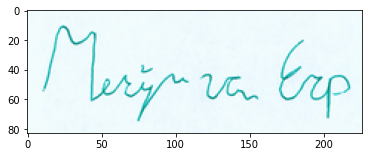

In [17]:
# Graph Image Forged
import matplotlib.pyplot as plt
img = plt.imread('/content/images/Dataset_Signature_Final/Dataset/dataset1/forge/02100001.png')
plt.imshow(img)

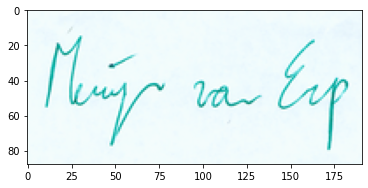

In [18]:
# Graph Image Real
import matplotlib.pyplot as plt
img = plt.imread('/content/images/Dataset_Signature_Final/Dataset/dataset1/real/00100001.png')
plt.imshow(img)

In [19]:
# Training File Real Count
count_real = 0

for root_dir, cur_dir, files in os.walk(r'/content/images/Dataset_Signature_Final/Dataset/dataset1/real'):
    count_real += len(files)
for root_dir, cur_dir, files in os.walk(r'/content/images/Dataset_Signature_Final/Dataset/dataset2/real'):
    count_real += len(files)
for root_dir, cur_dir, files in os.walk(r'/content/images/Dataset_Signature_Final/Dataset/dataset3/real'):
    count_real += len(files)
for root_dir, cur_dir, files in os.walk(r'/content/images/Dataset_Signature_Final/Dataset/dataset4/real'):
    count_real += len(files)

print('real signature file count in training:', count_real)

real signature file count in training: 270


In [20]:
# Training File Forge Count
count_forge = 0

for root_dir, cur_dir, files in os.walk(r'/content/images/Dataset_Signature_Final/Dataset/dataset1/forge'):
    count_forge += len(files)
for root_dir, cur_dir, files in os.walk(r'/content/images/Dataset_Signature_Final/Dataset/dataset1/forge'):
    count_forge += len(files)
for root_dir, cur_dir, files in os.walk(r'/content/images/Dataset_Signature_Final/Dataset/dataset1/forge'):
    count_forge += len(files)
for root_dir, cur_dir, files in os.walk(r'/content/images/Dataset_Signature_Final/Dataset/dataset1/forge'):
    count_forge += len(files)

print('forge signature file count in training:', count_forge)

forge signature file count in training: 240


In [21]:
# Sample File Real Count
count_real = 0

for root_dir, cur_dir, files in os.walk(r'/content/images/sample_Signature/sample_Signature/genuine'):
    count_real += len(files)

print('real signature file count in training:', count_real)

real signature file count in training: 150


In [22]:
# Sample File Forge Count
for root_dir, cur_dir, files in os.walk(r'/content/images/sample_Signature/sample_Signature/forged'):
    count_forge += len(files)

print('forge signature file count in training:', count_forge)

forge signature file count in training: 390


Text(0.5, 1.0, 'Grayscale image with cmap')

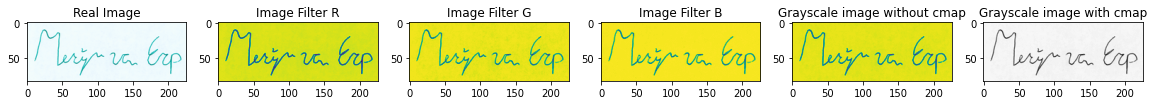

In [23]:
# Checking through different color layers
img = cv2.imread('/content/images/Dataset_Signature_Final/Dataset/dataset1/forge/02100001.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Red = img_rgb[:,:,0]
Green = img_rgb[:,:,1]
Blue = img_rgb[:,:,2]
Grey = 0.299*Red + 0.587*Green + 0.114*Blue

# Graph RGB & Greyscale
fig, ax = plt.subplots(ncols=6,figsize=(20,5))
ax[0].imshow(img_rgb)
ax[0].set_title('Real Image')
ax[1].imshow(Red)
ax[1].set_title('Image Filter R')
ax[2].imshow(Green)
ax[2].set_title('Image Filter G')
ax[3].imshow(Blue)
ax[3].set_title('Image Filter B')
ax[4].imshow(Grey)
ax[4].set_title('Grayscale image without cmap')
ax[5].imshow(Grey, cmap='gray')
ax[5].set_title('Grayscale image with cmap')

Text(0.5, 1.0, 'Real Image Resized 256x256')

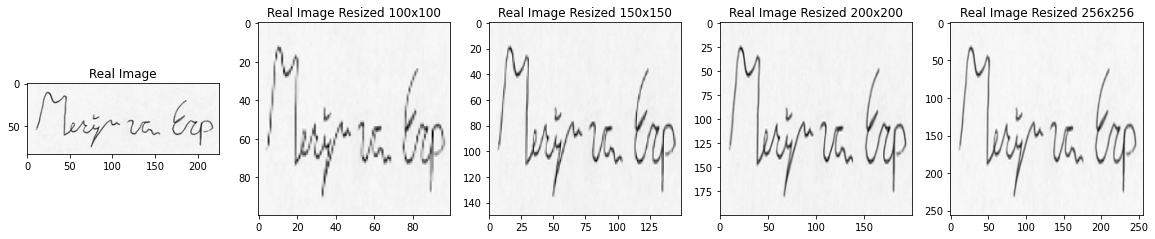

In [25]:
# Checking through different image sizes
img = cv2.imread('/content/images/Dataset_Signature_Final/Dataset/dataset1/forge/02100001.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_res100 = cv2.resize(img_gray, dsize=(100, 100))
img_res150 = cv2.resize(img_gray, dsize=(150, 150))
img_res200 = cv2.resize(img_gray, dsize=(200, 200))
img_res256 = cv2.resize(img_gray, dsize=(256, 256))

# Graph image
fig, ax = plt.subplots(ncols=5,figsize=(20,5))
ax[0].imshow(img_gray, cmap='gray')
ax[0].set_title('Real Image')
ax[1].imshow(img_res100, cmap='gray')
ax[1].set_title('Real Image Resized 100x100')
ax[2].imshow(img_res150, cmap='gray')
ax[2].set_title('Real Image Resized 150x150')
ax[3].imshow(img_res200, cmap='gray')
ax[3].set_title('Real Image Resized 200x200')
ax[4].imshow(img_res256, cmap='gray')
ax[4].set_title('Real Image Resized 256x256')

In the exploratory data analysis (EDA) we have found out that:
- The train image files consist of inequal numbers of genuine and forged signature image.
- The test image also files consist of inequal numbers of genuine and forged signature image.
- RGB filter does not show much difference for image colors, and grayscale seems to show better visibility for the image, which help with our classification model. We will be using grayscale as our image format color.
- We will be resizing image size to 256 x 256 for better visibility.

# V. Data Preprocessing

#### **Giving Label to Data**

In [35]:
data = []
labels = []

for a in range(len(gen_train)):
    for i in gen_train[a]:   
        image=load_img(i, color_mode='grayscale', 
        target_size= (256,256))
        image=np.array(image)
        image=np.repeat(image[..., np.newaxis], 3, -1)
        data.append(image)
        labels.append(0)
for a in range(len(forge_train)):
    for i in forge_train[a]:   
        image=load_img(i, color_mode='grayscale', 
        target_size= (256,256))
        image=np.array(image)
        image=np.repeat(image[..., np.newaxis], 3, -1)
        data.append(image)
        labels.append(1)


data = np.array(data)
labels = np.array(labels)

In [36]:
# Turn Labels into dataframe
df_labels = pd.DataFrame(labels,columns=['labels'])

In [37]:
# Showing Labels dataframe
df_labels

,labels
0,0
1,0
2,0
3,0
4,0
...,...
925,1
926,1
927,1
928,1


In [38]:
# Normalization data
data = data/255

#### **Get Inference Data**

In [42]:
# Get Data for Model Inference

x_train_test, x_inf,  y_train_test, y_inf = train_test_split(data, df_labels, shuffle=True, test_size=0.01,random_state=26)

In [40]:
# Shape Checking Data Inferensial
y_inf

,labels
372,0
117,0
299,0
133,0
766,1
529,1
184,0
813,1
247,0
823,1


#### **Split Data into Train, Validation, and Test Data**

In [41]:
# Splitting Data set into Train, Test, and Validation
x_train_full, x_test,  y_train_full, y_test = train_test_split(x_train_test, y_train_test, shuffle=True, test_size=0.2,random_state=26)

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, shuffle=True, test_size=0.2,random_state=26)

print("Training data shape: {}".format(x_train.shape))
print("Validation data shape: {}".format(x_val.shape))
print("Testing data shape: {}".format(x_test.shape))

Training data shape: (588, 256, 256, 3)
Validation data shape: (148, 256, 256, 3)
Testing data shape: (184, 256, 256, 3)


#### **Image Preprocessing**

In [43]:
# Image Preprocessing for Training
train_datagen = ImageDataGenerator(
    rotation_range=30,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.4,1.5],
    zoom_range=0.3
    )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# VI. Model Definition

The model that we will be using is CNN Model because we are doing image classification and CNN is one of the common algorithm to use for image classification. We will also test premade model of VGG16, Resnet50, InceptionV3, and Xception.

#### **A. Model CNN I**


In [49]:
cnn_model = Sequential()

cnn_model.add(Conv2D(16,(3,3),input_shape=(256,256,3),activation='relu'))
cnn_model.add(MaxPooling2D(3,3))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32,(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64,(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 84, 84, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 84, 84, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 82, 82, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 41, 41, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 41, 41, 32)       

In [50]:
# Definition Callbacks
es_cnn = [EarlyStopping(monitor='val_loss', verbose=1,patience=10,restore_best_weights=True)]

#### **B. Model Training Computer Vision with VGG16**

In [53]:
# Definition & Import of Transfer Learning with Model VGG16
from tensorflow.keras.applications import VGG16

model_vgg= VGG16(include_top=False, weights='imagenet',input_shape=(256,256,3),classes=2)

58900480/58889256 [==============================] - 0s 0us/step


In [54]:
# Taking Weight of VGG16 Model to Train our model
x_train_vgg = model_vgg.predict(x_train,verbose=1)
x_val_vgg = model_vgg.predict(x_val,verbose=1)

5/5 [==============================] - 3s 662ms/step


In [56]:
# vgg_model arsitecture 
vgg_model = Sequential([
    Flatten(input_shape=[8,8,512]),
    Dense(256,activation = "relu"),
    Dropout(rate=0.5),
    Dense(1, activation = "sigmoid")
])
vgg_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [57]:
# Callbacks definition
es_vgg = [EarlyStopping(monitor='val_loss', verbose=1,patience=10,restore_best_weights=True)]

#### **C. Model Training Computer Vision with ResNet50**

In [60]:
# Definition & Import of Transfer Learning with Model ResNet50
from tensorflow.keras.applications import ResNet50

model_resnet50= ResNet50(include_top=False, weights='imagenet',classes= 2,input_shape=(256,256,3))

94781440/94765736 [==============================] - 1s 0us/step


In [61]:
# Taking Weight of ResNet50 Model to Train our model
x_train_resnet50 = model_resnet50.predict(x_train,verbose=1)
x_val_resnet50 = model_resnet50.predict(x_val,verbose=1)

5/5 [==============================] - 1s 275ms/step


In [63]:
# ResNet50_model arsitecture 
resnet50_model = Sequential([
    Flatten(input_shape=[8,8,2048]),
    Dense(256,activation = "relu"),
    Dropout(rate=0.5),
    Dense(1, activation = "sigmoid")
])
resnet50_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [64]:
# Callbacks definition
es_resnet50 = [EarlyStopping(monitor='val_loss', verbose=1,patience=10,restore_best_weights=True)]

#### **D. Model Training Computer Vision with InceptionV3**

In [66]:
# Definition & Import of Transfer Learning with Model InceptionV3
from tensorflow.keras.applications import InceptionV3

model_InceptionV3= InceptionV3(include_top=False, weights='imagenet',input_shape=(256,256,3),classes=2)

87924736/87910968 [==============================] - 0s 0us/step


In [67]:
# Taking Weight of InceptionV3 Model to Train our model
x_train_InceptionV3 = model_InceptionV3.predict(x_train,verbose=1)
x_val_InceptionV3 = model_InceptionV3.predict(x_val,verbose=1)

5/5 [==============================] - 1s 338ms/step


In [68]:
# InceptionV3_model arsitecture 
InceptionV3_model = Sequential([
    Flatten(input_shape=[6,6,2048]),
    Dense(256,activation = "relu"),
    Dropout(rate=0.5),
    Dense(1, activation = "sigmoid")
])
InceptionV3_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

In [69]:
# Callbacks definition
es_inceptionV3 = [EarlyStopping(monitor='val_loss', verbose=1,patience=10,restore_best_weights=True)]

#### **E. Model Training Computer Vision with Xception**

In [71]:
# Definition & Import of Transfer Learning with Model Xception
from tensorflow.keras.applications import Xception

model_xception= Xception(include_top=False, weights='imagenet',input_shape=(256,256,3),classes=2)

83697664/83683744 [==============================] - 1s 0us/step


In [72]:
# Taking Weight of Xception Model to Train our model
x_train_xception = model_xception.predict(x_train,verbose=1)
x_val_xception = model_xception.predict(x_val,verbose=1)

5/5 [==============================] - 2s 381ms/step


In [73]:
# Xception_model arsitecture 
xception_model = Sequential([
    Flatten(input_shape=[8,8,2048]),
    Dense(256,activation = "relu"),
    Dropout(rate=0.5),
    Dense(1, activation = "sigmoid")
])
xception_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

In [75]:
# Callbacks definition
es_xception = [EarlyStopping(monitor='val_loss', verbose=1,patience=10,restore_best_weights=True)]

# VII. Model Training

#### **A. Model CNN I**

In [51]:
# Training the model
hist_cnn =  cnn_model.fit(x_train,y_train,batch_size=32,
            validation_data=(x_val,y_val),validation_batch_size=32,
            epochs=100,callbacks=es_cnn)

Epoch 1/100
19/19 [==============================] - 14s 72ms/step - loss: 1.1322 - accuracy: 0.4694 - val_loss: 0.6907 - val_accuracy: 0.5270
Epoch 2/100
19/19 [==============================] - 1s 35ms/step - loss: 0.6875 - accuracy: 0.5527 - val_loss: 0.6891 - val_accuracy: 0.5270
Epoch 3/100
19/19 [==============================] - 1s 34ms/step - loss: 0.6846 - accuracy: 0.5527 - val_loss: 0.6851 - val_accuracy: 0.5270
Epoch 4/100
19/19 [==============================] - 1s 35ms/step - loss: 0.6848 - accuracy: 0.5425 - val_loss: 0.6837 - val_accuracy: 0.5270
Epoch 5/100
19/19 [==============================] - 1s 35ms/step - loss: 0.6667 - accuracy: 0.5527 - val_loss: 0.6657 - val_accuracy: 0.5270
Epoch 6/100
19/19 [==============================] - 1s 36ms/step - loss: 0.6505 - accuracy: 0.5867 - val_loss: 0.6477 - val_accuracy: 0.5473
Epoch 7/100
19/19 [==============================] - 1s 36ms/step - loss: 0.6047 - accuracy: 0.6412 - val_loss: 0.6026 - val_accuracy: 0.6892
Epoch

#### **B. Model Training Computer Vision with VGG16**

In [58]:
hist_vgg = vgg_model.fit(x_train_vgg,y_train,epochs=100,batch_size=32,validation_data=(x_val_vgg,y_val),callbacks=[es_vgg])

Epoch 1/100
19/19 [==============================] - 1s 15ms/step - loss: 2.8542 - accuracy: 0.5612 - val_loss: 0.5040 - val_accuracy: 0.7635
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.5241 - accuracy: 0.7959 - val_loss: 0.2456 - val_accuracy: 0.9459
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2331 - accuracy: 0.9133 - val_loss: 0.1752 - val_accuracy: 0.9730
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1193 - accuracy: 0.9660 - val_loss: 0.1151 - val_accuracy: 0.9865
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0845 - accuracy: 0.9779 - val_loss: 0.0956 - val_accuracy: 0.9797
Epoch 6/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0691 - accuracy: 0.9830 - val_loss: 0.0721 - val_accuracy: 0.9932
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0513 - accuracy: 0.9898 - val_loss: 0.0548 - val_accuracy: 0.9865
Epoch 8/100


#### **C. Model Training Computer Vision with ResNet50**

In [65]:
hist_resnet50 = resnet50_model.fit(x_train_resnet50,y_train,epochs=100,batch_size=32,validation_data=(x_val_resnet50,y_val),verbose=1,callbacks=es_resnet50)

Epoch 1/100
19/19 [==============================] - 1s 37ms/step - loss: 11.7757 - accuracy: 0.5102 - val_loss: 4.4296 - val_accuracy: 0.5946
Epoch 2/100
19/19 [==============================] - 0s 20ms/step - loss: 2.4077 - accuracy: 0.5969 - val_loss: 0.6068 - val_accuracy: 0.6351
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 0.6225 - accuracy: 0.6276 - val_loss: 0.5509 - val_accuracy: 0.7500
Epoch 4/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5404 - accuracy: 0.6548 - val_loss: 0.5672 - val_accuracy: 0.6419
Epoch 5/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5385 - accuracy: 0.6599 - val_loss: 0.5576 - val_accuracy: 0.6014
Epoch 6/100
19/19 [==============================] - 0s 20ms/step - loss: 0.5172 - accuracy: 0.6497 - val_loss: 0.4918 - val_accuracy: 0.7703
Epoch 7/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5100 - accuracy: 0.6939 - val_loss: 0.5262 - val_accuracy: 0.6554
Epoch

#### **D. Model Training Computer Vision with InceptionV3**

In [70]:
hist_InceptionV3 = InceptionV3_model.fit(x_train_InceptionV3,y_train,epochs=100,batch_size=32,validation_data=(x_val_InceptionV3,y_val),verbose=1,callbacks=es_inceptionV3)

Epoch 1/100
19/19 [==============================] - 1s 23ms/step - loss: 7.6265 - acc: 0.6190 - val_loss: 2.0200 - val_acc: 0.7973
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 2.2488 - acc: 0.7789 - val_loss: 0.4495 - val_acc: 0.8851
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.4640 - acc: 0.9048 - val_loss: 0.2697 - val_acc: 0.9054
Epoch 4/100
19/19 [==============================] - 0s 13ms/step - loss: 0.2419 - acc: 0.9456 - val_loss: 0.2522 - val_acc: 0.9054
Epoch 5/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0776 - acc: 0.9728 - val_loss: 0.1377 - val_acc: 0.9595
Epoch 6/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0680 - acc: 0.9779 - val_loss: 0.0810 - val_acc: 0.9662
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0376 - acc: 0.9881 - val_loss: 0.1125 - val_acc: 0.9595
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.

#### **E. Model Training Computer Vision with Xception**

In [76]:
hist_xception = xception_model.fit(x_train_xception,y_train,epochs=100,batch_size=32,validation_data=(x_val_xception,y_val),verbose=1,callbacks=es_xception)

Epoch 1/100
19/19 [==============================] - 1s 34ms/step - loss: 4.4986 - acc: 0.6565 - val_loss: 2.5141 - val_acc: 0.7568
Epoch 2/100
19/19 [==============================] - 0s 20ms/step - loss: 1.4202 - acc: 0.8044 - val_loss: 1.6916 - val_acc: 0.7905
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 0.5715 - acc: 0.8707 - val_loss: 0.1849 - val_acc: 0.9392
Epoch 4/100
19/19 [==============================] - 0s 20ms/step - loss: 0.1664 - acc: 0.9490 - val_loss: 0.1318 - val_acc: 0.9595
Epoch 5/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1230 - acc: 0.9558 - val_loss: 0.0763 - val_acc: 0.9662
Epoch 6/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0810 - acc: 0.9745 - val_loss: 0.0818 - val_acc: 0.9662
Epoch 7/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0615 - acc: 0.9745 - val_loss: 0.0789 - val_acc: 0.9595
Epoch 8/100
19/19 [==============================] - 0s 16ms/step - loss: 0.

# VIII. Model Evaluation

#### **A. Model CNN I**

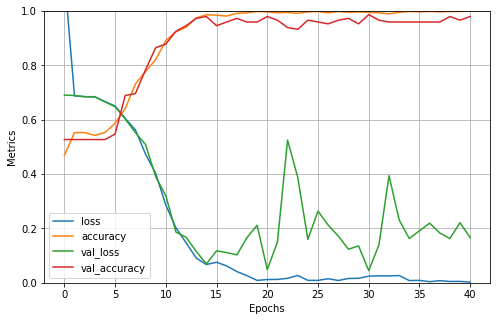

In [78]:
# Plotting history of the model
pd.DataFrame(hist_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [80]:
# Evaluate result
eval_test_cnn = cnn_model.evaluate(x_test,y_test)
eval_train_cnn = cnn_model.evaluate(x_train,y_train)
print(f'Nilai Accuracy Model CNN Testing II = {round((eval_test_cnn[1]),3)} ')
print(f'Nilai Accuracy Model CNN Training II = {round((eval_train_cnn[1]),3)} ')

19/19 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 0.9983
Nilai Accuracy Model CNN Testing II = 0.957 
Nilai Accuracy Model CNN Training II = 0.998 


In [88]:
# Predicting y result
y_cnn_pred_test=cnn_model.predict(x_test)

Text(60.0, 0.5, 'Actual')

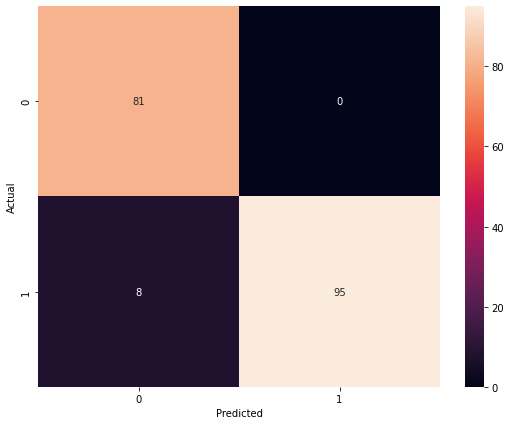

In [89]:
# Graphing confusion matrix
y_cnn_pred_test_list = []

for ele in y_cnn_pred_test:
  if ele > 0.5:
    y_cnn_pred_test_list.append(1)
  else :
    y_cnn_pred_test_list.append(0)
cm_cnn = tf.math.confusion_matrix(labels=y_test, predictions=y_cnn_pred_test_list)

plt.figure(figsize=(9,7))
sns.heatmap(cm_cnn,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In this first CNN model, we can see that the model accuracy is quite good in comparison to the validation accuracy. Despite that, the validation loss fluctuate a lot. Although the model is learning quite efficiently, the validation loss fluctuation is a consideration that the model need improvement.

Additionally, based on the confusion matrix the distribution between the prediction is quite good with only 8 forged signature predicted as real.

#### **B. Model Training Computer Vision with VGG16**

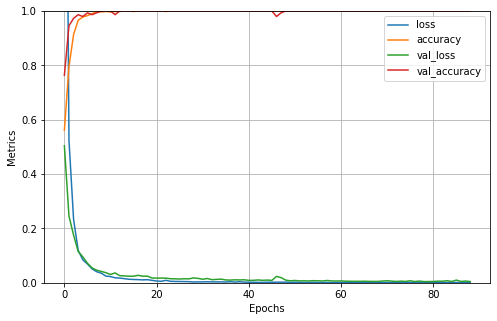

In [90]:
# Plotting history of the model
pd.DataFrame(hist_vgg.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [96]:
# Define x
x_test_vgg = model_vgg.predict(x_test,verbose=1)

6/6 [==============================] - 3s 677ms/step


In [99]:
# Model evaluation
eval_test_vgg=vgg_model.evaluate(x_test_vgg,y_test)
eval_train_vgg=vgg_model.evaluate(x_train_vgg,y_train)
print(f'Nilai Accuracy VGG16 Testing (setelah Improvement) = {round((eval_test_vgg[1]),3)} ')
print(f'Nilai Accuracy VGG16 Training (setelah Improvement) = {round((eval_train_vgg[1]),3)} ')

19/19 [==============================] - 0s 3ms/step - loss: 8.3946e-05 - accuracy: 1.0000
Nilai Accuracy VGG16 Testing (setelah Improvement) = 0.989 
Nilai Accuracy VGG16 Training (setelah Improvement) = 1.0 


In [98]:
# Prediction with VGG16
y_vgg_pred_test=vgg_model.predict(x_test_vgg)

Text(60.0, 0.5, 'Actual')

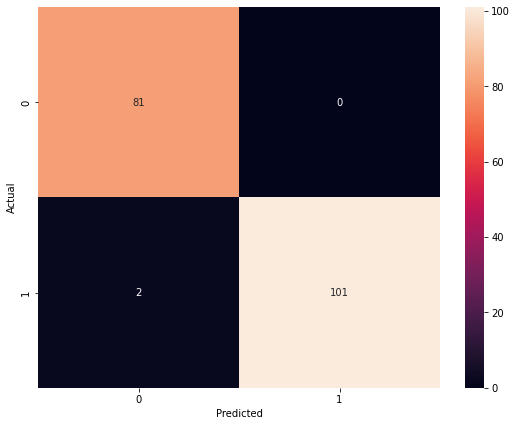

In [100]:
# Confusion Matrix
y_vgg_test = []

for ele in y_vgg_pred_test:
  if ele > 0.5:
    y_vgg_test.append(1)
  else :
    y_vgg_test.append(0)
cm_vgg = tf.math.confusion_matrix(labels=y_test, predictions=y_vgg_test)

plt.figure(figsize=(9,7))
sns.heatmap(cm_vgg,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In this VGG16 model, we can see that the model accuracy and loss is quite good in comparison to the validation accuracy and loss.This model seems to be a good fit and is learning quite efficiently.

Additionally, based on the confusion matrix the distribution between the prediction is quite good with only 2 forged signature predicted as real.

#### **C. Model Training Computer Vision with ResNet50**

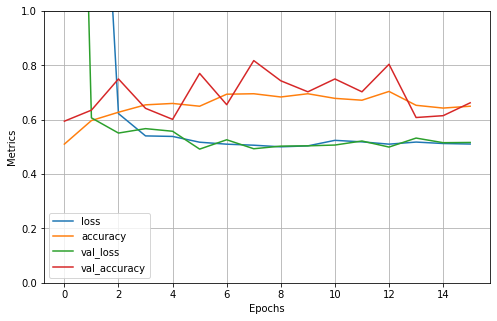

In [91]:
# Plotting history of the model
pd.DataFrame(hist_resnet50.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [101]:
# Define x
x_test_resnet50 = model_resnet50.predict(x_test,verbose=1)

6/6 [==============================] - 1s 281ms/step


In [102]:
# Model evaluation
eval_test_resnet50=resnet50_model.evaluate(x_test_resnet50,y_test)
eval_train_resnet50=resnet50_model.evaluate(x_train_resnet50,y_train)
print(f'Nilai Accuracy ResNet50 Testing (setelah Improvement) = {round((eval_test_resnet50[1]),3)} ')
print(f'Nilai Accuracy ResNet50 Training (setelah Improvement) = {round((eval_train_resnet50[1]),3)} ')

19/19 [==============================] - 0s 7ms/step - loss: 0.4544 - accuracy: 0.7806
Nilai Accuracy ResNet50 Testing (setelah Improvement) = 0.755 
Nilai Accuracy ResNet50 Training (setelah Improvement) = 0.781 


In [103]:
# Prediction with ResNet50
y_resnet50_pred_test=resnet50_model.predict(x_test_resnet50)

Text(60.0, 0.5, 'Actual')

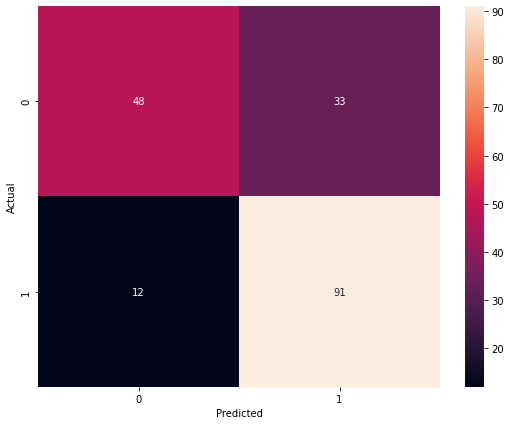

In [104]:
# Confusion Matrix 
y_resnet50_test = []

for ele in y_resnet50_pred_test:
  if ele > 0.5:
    y_resnet50_test.append(1)
  else :
    y_resnet50_test.append(0)
cm_resnet50 = tf.math.confusion_matrix(labels=y_test, predictions=y_resnet50_test)

plt.figure(figsize=(9,7))
sns.heatmap(cm_resnet50,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In this ResNet50 model, we can see that the model loss is quite good in comparison to the validation loss. Despite that, the model accuracy and the validation accuracy seems to fluctuate a lot. This model seems to be an under fit and is learning not quite good.

Additionally, based on the confusion matrix the distribution between the prediction is pretty bad with 12 forged signature predicted as real and 33 real signature predicted as forged.

#### **D. Model Training Computer Vision with InceptionV3**

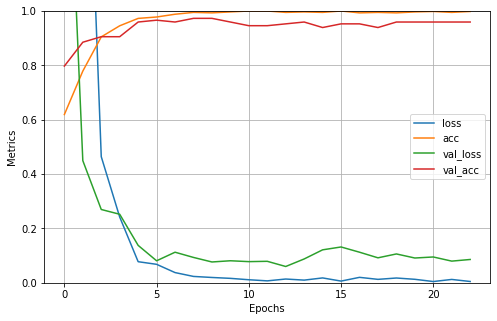

In [92]:
# Plotting history of the model
pd.DataFrame(hist_InceptionV3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [105]:
# Define x
x_test_InceptionV3 = model_InceptionV3.predict(x_test,verbose=1)

6/6 [==============================] - 2s 322ms/step


In [107]:
# Model evaluation
eval_test_InceptionV3=InceptionV3_model.evaluate(x_test_InceptionV3,y_test)
eval_train_InceptionV3=InceptionV3_model.evaluate(x_train_InceptionV3,y_train)
print(f'Nilai Accuracy Inception V3 Testing (setelah Improvement) = {round((eval_test_InceptionV3[1]),3)} ')
print(f'Nilai Accuracy Inception V3 Training (setelah Improvement) = {round((eval_train_InceptionV3[1]),3)} ')

19/19 [==============================] - 0s 5ms/step - loss: 2.3951e-04 - acc: 1.0000
Nilai Accuracy Inception V3 Testing (setelah Improvement) = 0.946 
Nilai Accuracy Inception V3 Training (setelah Improvement) = 1.0 


In [108]:
# Prediction with Inception V3
y_InceptionV3_pred_test=InceptionV3_model.predict(x_test_InceptionV3)

Text(60.0, 0.5, 'Actual')

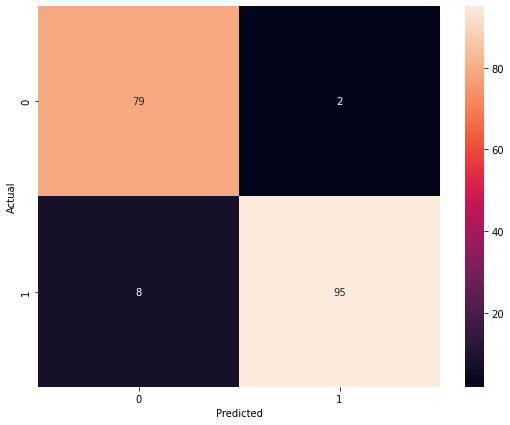

In [109]:
# Confusion Matrix 
y_InceptionV3_test = []

for ele in y_InceptionV3_pred_test:
  if ele > 0.5:
    y_InceptionV3_test.append(1)
  else :
    y_InceptionV3_test.append(0)
cm_InceptionV3 = tf.math.confusion_matrix(labels=y_test, predictions=y_InceptionV3_test)

plt.figure(figsize=(9,7))
sns.heatmap(cm_InceptionV3,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In this InceptionV3 model, we can see that the model accuracy and loss is quite good in comparison to the validation accuracy and loss, although the loss distance is still quite far. This model seems to be learning decently.

Additionally, based on the confusion matrix the distribution between the prediction is pretty bad with 8 forged signature predicted as real and 2 real signature predicted as forged.

#### **E. Model Training Computer Vision with Xception**

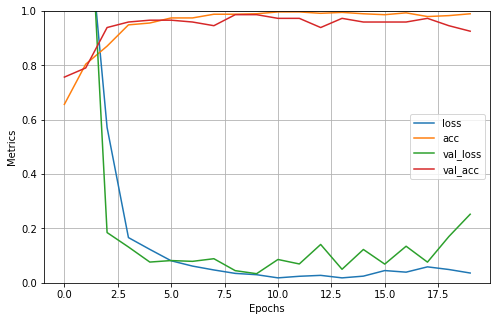

In [93]:
# Plotting history of the model
pd.DataFrame(hist_xception.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [110]:
# Define x
x_test_xception = model_xception.predict(x_test,verbose=1)

6/6 [==============================] - 2s 355ms/step


In [111]:
# Model evaluation
eval_test_xception=xception_model.evaluate(x_test_xception,y_test)
eval_train_xception=xception_model.evaluate(x_train_xception,y_train)
print(f'Nilai Accuracy Xception Testing (setelah Improvement) = {round((eval_test_xception[1]),3)} ')
print(f'Nilai Accuracy Xception Training (setelah Improvement) = {round((eval_train_xception[1]),3)} ')

19/19 [==============================] - 0s 7ms/step - loss: 0.0029 - acc: 1.0000
Nilai Accuracy Xception Testing (setelah Improvement) = 0.989 
Nilai Accuracy Xception Training (setelah Improvement) = 1.0 


In [112]:
# Prediction with Xception
y_xception_pred_test=xception_model.predict(x_test_xception)

Text(60.0, 0.5, 'Actual')

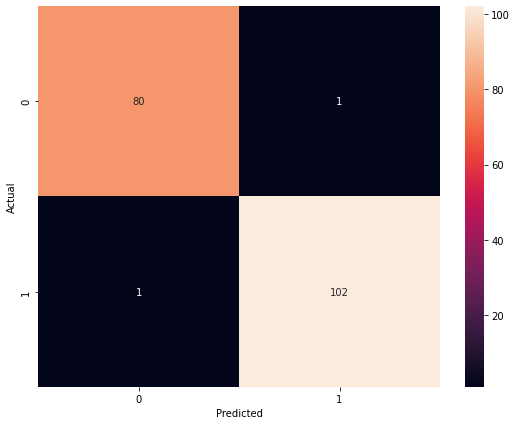

In [113]:
# Confusion Matrix 
y_xception_test = []

for ele in y_xception_pred_test:
  if ele > 0.5:
    y_xception_test.append(1)
  else :
    y_xception_test.append(0)
cm_xception = tf.math.confusion_matrix(labels=y_test, predictions=y_xception_test)

plt.figure(figsize=(9,7))
sns.heatmap(cm_xception,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In this InceptionV3 model, we can see that the model accuracy and loss is quite good in comparison to the validation accuracy and loss, although the loss distance is still quite far. This model seems to be learning decently.

Additionally, based on the confusion matrix the distribution between the prediction is quite good with 1 forged signature predicted as real and 1 real signature predicted as forged.

#### **Conclusion**

In conclusion, we decided to choose VGG16 model as our best model, since it showed a good-fit model and perform the best prediction out of all our model, with only 2 wrong predicition. We will be using this VGG16 model as the basis model of our prediction.

# IX. Model Saving

In [114]:
# Checking model
vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 8,389,121
Trainable params: 8,389,121
Non-trainable params: 0
_________________________________________________________________


In [115]:
# Freeze Model
vgg_model.trainable=False

In [116]:
vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 8,389,121
Trainable params: 0
Non-trainable params: 8,389,121
_________________________________________________________________


In [117]:
# Model saving
vgg_model.save("signature_model")

# IX. Model Inference

In [119]:
# Display Inference-Array
x_inf.shape

(10, 256, 256, 3)

In [121]:
# Predict with vgg Model
x_inf_final = model_vgg.predict(x_inf,verbose=0)

In [122]:
# Predict using vgg Model
y_pred_inf = vgg_model.predict(x_inf_final)
y_pred_inf

array([[1.9065931e-04],
       [2.9212912e-04],
       [4.7183592e-05],
       [8.5802982e-05],
       [1.4835827e-04],
       [1.5734546e-04],
       [7.6644916e-05],
       [9.9972337e-01],
       [9.9999928e-01],
       [8.5802982e-05]], dtype=float32)

In [123]:
# Predict the class of y_pred_inf
y_pred_inf_2 = ((y_pred_inf > 0.5)+0).ravel()
y_pred_inf_2

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [125]:
# Predict
y_inf['VGG Prediction'] = y_pred_inf_2
y_inf

,labels,VGG Prediction
4,0,0
272,0,0
350,0,0
105,0,0
130,0,0
222,0,0
136,0,0
506,1,1
665,1,1
328,0,0


From the result of this inference data, we can see that the VGG16 Model that we chose as our best model did worked with 100% accuracy in prediction of new data. Despite that, since we have only little value of inference data here, the result of the prediction accuracy can change with new datas, especially in big amount.

# XI. Cosine Similarity

To make sure that our model can properly differentiate different signatures in the database, we will also be adding cosine similarity in addition to our model. This is so we can actually check the signature properly.

In [127]:
# Define functions

# Repeat axis to treat greyscale as RGB function
def repeat_axis(x):
    rgb_batch = np.repeat(x[..., np.newaxis], 3, -1)
    return rgb_batch

# Cosine similarity function
def cosine_similarity(x,y):
    dot_product = x@y
    cos = dot_product/(np.linalg.norm(x) * np.linalg.norm(y))
    return cos

# Calculating average cosine similarity function
def avg_cos_similar (a,b,c,d,e,f):
    if (a == f).all() or (b == f).all() or (c == f).all() or (e == f).all() or (d == f).all() :
        avg_cos = (cosine_similarity(a,f) + cosine_similarity(b,f) + cosine_similarity(c,f) + cosine_similarity(d,f) + cosine_similarity(e,f)-1)/4        
    else:
        avg_cos = (cosine_similarity(a,f) + cosine_similarity(b,f) + cosine_similarity(c,f) + cosine_similarity(d,f) + cosine_similarity(e,f))/5
    return round(avg_cos,5)

In [151]:
# Input test image
image1=load_img(f"/content/images/Dataset_Signature_Final/Dataset/dataset2/real/00101001.png", color_mode='grayscale', target_size= (256,256,3))
image2=load_img(f"/content/images/Dataset_Signature_Final/Dataset/dataset2/real/00102001.png", color_mode='grayscale', target_size= (256,256,3))
image3=load_img(f"/content/images/Dataset_Signature_Final/Dataset/dataset2/real/00103001.png", color_mode='grayscale', target_size= (256,256,3))
image4=load_img(f"/content/images/Dataset_Signature_Final/Dataset/dataset2/real/00104001.png", color_mode='grayscale', target_size= (256,256,3))
image5=load_img(f"/content/images/Dataset_Signature_Final/Dataset/dataset2/real/00105001.png", color_mode='grayscale', target_size= (256,256,3))
image6=load_img("/content/images/Dataset_Signature_Final/Dataset/dataset2/forge/02204001.png", color_mode='grayscale', target_size= (256,256,3))
image7=load_img("/content/images/Dataset_Signature_Final/Dataset/dataset2/forge/02102006.png", color_mode='grayscale', target_size= (256,256,3))


image1=np.array(image1)/255
image2=np.array(image2)/255
image3=np.array(image3)/255
image4=np.array(image4)/255
image5=np.array(image5)/255
image6=np.array(image6)/255
image7=np.array(image6)/255


In [152]:
# Convert images
image1=image1[np.newaxis,...]
image2=image2[np.newaxis,...]
image3=image3[np.newaxis,...]
image4=image4[np.newaxis,...]
image5=image5[np.newaxis,...]
image6=image6[np.newaxis,...]
image7=image7[np.newaxis,...]
image1.shape

(1, 256, 256)

In [153]:
# Convert images axis
image1=repeat_axis(image1)
image2=repeat_axis(image2)
image3=repeat_axis(image3)
image4=repeat_axis(image4)
image5=repeat_axis(image5)
image6=repeat_axis(image6)
image7=repeat_axis(image7)


#### **Trying Cosine Similarity with VGG16**

In [154]:
# Create model that fit the image
model_VGG16_2= VGG16(include_top=False, weights='imagenet',input_shape=(256,256,3),classes=2)

In [155]:
# Predict with VGG16
vgg16_image1= model_VGG16_2.predict(image1)
vgg16_image2= model_VGG16_2.predict(image2)
vgg16_image3= model_VGG16_2.predict(image3)
vgg16_image4= model_VGG16_2.predict(image4)
vgg16_image5= model_VGG16_2.predict(image5)
vgg16_image6= model_VGG16_2.predict(image6)
vgg16_image7= model_VGG16_2.predict(image7)

In [156]:
# Reshape image for calculation
vgg16_image1=vgg16_image1.reshape(-1)
vgg16_image2=vgg16_image2.reshape(-1)
vgg16_image3=vgg16_image3.reshape(-1)
vgg16_image4=vgg16_image4.reshape(-1)
vgg16_image5=vgg16_image5.reshape(-1)
vgg16_image6=vgg16_image6.reshape(-1)
vgg16_image7=vgg16_image7.reshape(-1)

In [159]:
# Show cosine similarity
print(f'nilai Cosine Similarity Unggahan Forge adalah {avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image6)}')
print(f'nilai Cosine Similarity Image I adalah {avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image1)}')
print(f'nilai Cosine Similarity Image II adalah {avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image2)}')
print(f'nilai Cosine Similarity Image III adalah {avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image3)}')
print(f'nilai Cosine Similarity Image IV adalah {avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image4)}')
print(f'nilai Cosine Similarity Image V adalah {avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image5)}')

nilai Cosine Similarity Unggahan Forge adalah 0.95187
nilai Cosine Similarity Image I adalah 0.97606
nilai Cosine Similarity Image II adalah 0.97687
nilai Cosine Similarity Image III adalah 0.97808
nilai Cosine Similarity Image IV adalah 0.97844
nilai Cosine Similarity Image V adalah 0.97922


In [165]:
# Define variable
cosin1 = avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image1)
cosin2 = avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image2)
cosin3 = avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image3)
cosin4 = avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image4)
cosin5 = avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image5)
cosin6 = avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image6)
cosin7 = avg_cos_similar(vgg16_image1,vgg16_image2,vgg16_image3,vgg16_image4,vgg16_image5,vgg16_image7)

In [163]:
# Testing similar forgery sign
if ((cosin1+cosin2+cosin3+cosin4+cosin5)/5-cosin6)>0.036:
  print("Tanda tangan terdeteksi tidak relevan")
else:
  print("Tanda tangan relevan")

Tanda tangan relevan


In [166]:
# Testing not similar forgery sign
if ((cosin1+cosin2+cosin3+cosin4+cosin5)/5-cosin7)>0.036:
  print("Tanda tangan terdeteksi tidak relevan")
else:
  print("Tanda tangan relevan")

Tanda tangan terdeteksi tidak relevan


# XII. Conclusion

In conclusion we have found that:

From Exploratory Data Analysis:
- The train image files consist of inequal numbers of genuine and forged signature image.
- The test image also files consist of inequal numbers of genuine and forged signature image.
- RGB filter does not show much difference for image colors, and grayscale seems to show better visibility for the image, which help with our classification model. We will be using grayscale as our image format color.
- We will be resizing image size to 256 x 256 for better visibility.

From Model Evaluation:
- Correct prediction 0 is when signature is real, and 1 is when signature is forge.
- Incorrect prediction 0 is when signature is forged but predicted as real, and 1 is when signature is real but predicted as forged.
- VGG16 is the best model working, and Resnet50 is the wost model working. 
- We decided to choose VGG16 model as our best model, since it showed a good-fit model and perform the best prediction out of all our model, with only 2 wrong predicition.
- We will be using this VGG16 model as the basis model of our prediction.

From Model Inference:
- The VGG16 Model that we chose as our best model worked with 100% accuracy in prediction of new data. 
- Despite that, since we have only little value of inference data here, the result of the prediction accuracy can change with new datas, especially in big amount.

Future Improvement:
- More signature data to predict with more accuracy
- More inference data to predict new data with more accuracy
- To try other different Deep Learning model algorithm
- More improved signature detection model with user id verification
- Create a more advanced model that can add signatures on the go and process it right away